# Universal Differential Equation for a 2D PDE heat equation

In this notebook we focus on the optimization of the global diffusivity parameter of the 2D heat equation without boundary conditions, 
$$
\frac{\partial T}{\partial t} = D \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right), \qquad T(x,y,0) = g(x,y)
$$
where $T(x,y,t)$ the temperature field, and $D$ an unknown global constant. 

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100          # size of the grid
Δx, Δy = 1, 1              # lenght of each element in the grid (meters)
Δt = 0.02                  # temporal stepsize in the numerical method
t₁ = 1                     # final time in simulation
 
D₀ = 1                     # real diffusivity parameters
tolnl = 1e-4               # tolerance of the numerical method
itMax = 50                 # maximum number of iterations of numerical method
damp = 0.85                # damping factor of numerical method
dτsc   = 1.0/3.0           # step in implicit numerical method
ϵ     = 1e-4               # small number
cfl  = max(Δx^2,Δy^2)/4.1; # stability parameter

We first define the functions that rule the evolution of the temperature field. We use a semi-implicit method (more ref)

In [3]:
function heatflow(T, D::Real, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        #println("total iterations: ", iter)
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [4]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

## Generate reference dataset

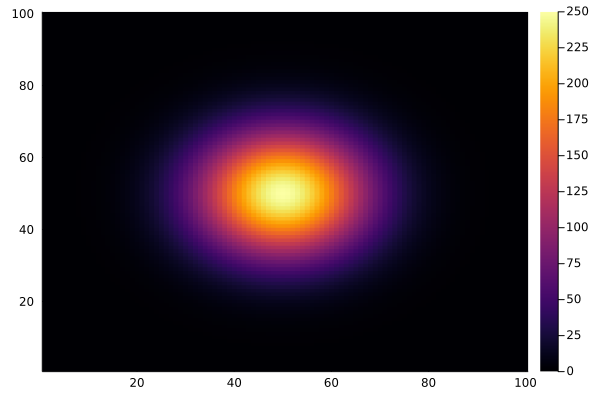

In [5]:
p = (Δx, Δy, Δt, t₁)

# initial condition
T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

# simulated evolution
T₁ = copy(T₀)
T₁ = heatflow(T₁, D₀, p, 1e-4)

heatmap(T₀, clim=(0, maximum(T₀)))

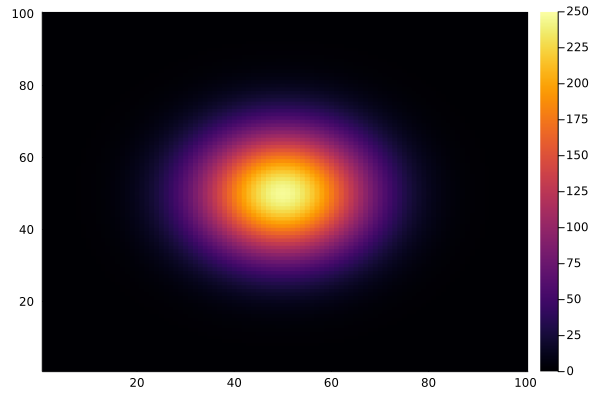

In [6]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [7]:
maximum(T₁.-T₀)

0.46434073372136453

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.5284106153748934

## Automatic differentiation on the heat equation with respect to D

We perform automatic differentiation on the 2D PDE with respect to the diffusivity (D) in order to optimize it.

In [9]:
function loss(T, θ, p)
    uD = θ[1] 
    T = heatflow(T, uD, p)
    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))
    return l_H
end

loss (generic function with 1 method)

We can easily evaluate the loss function and its gradient with respect to $D$ using `Zygote`

In [10]:
T = copy(T₀)

loss_uD, back_uD = Zygote.pullback(D -> loss(T, [D], p), 100)

(25.424471112802085, Zygote.var"#41#42"{typeof(∂(#20))}(∂(#20)))

We test different D values in order to observe how the loss and the backpropagated gradients change.

In [10]:
all_D = LinRange(D₀/2, 2D₀, 50)
all_loss = zeros(0)
all_grad = zeros(0)

for d in all_D
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), d)
    
    println(d)
    println(loss_uD, back_uD(1))
    
    append!(all_loss, loss_uD)
    append!(all_grad, back_uD(1)[1])
end

0.5
0.20605312838458512(-0.6405917874522978,)
0.5306122448979592
0.18626351170774705(-0.6404409301932763,)
0.5612244897959183
0.16648047210349207(-0.6402677694573196,)
0.5918367346938775
0.14670595031732964(-0.640072595380953,)
0.6224489795918368
0.12694185672902428(-0.6398556978464328,)
0.653061224489796
0.10719007131650318(-0.6396173661567763,)
0.6836734693877551
0.14462452804381906(-0.5570554295691761,)
0.7142857142857143
0.12732386093617604(-0.5570258941396928,)
0.7448979591836735
0.11003084934292781(-0.5569731230376597,)
0.7755102040816326
0.09274753753035256(-0.556897323432458,)
0.8061224489795918
0.07547594285914948(-0.5567987100883772,)
0.8367346938775511
0.05821805477647786(-0.5566775049639388,)
0.8673469387755102
0.04097583387221029(-0.5565339365547283,)
0.8979591836734694
0.023751211045655567(-0.5563682365390041,)
0.9285714285714286
0.00654608782225724(-0.5561804955815743,)
0.9591836734693877
0.010637674587232525(0.5559713222426939,)
0.9897959183673469
0.00538269338937859(-0

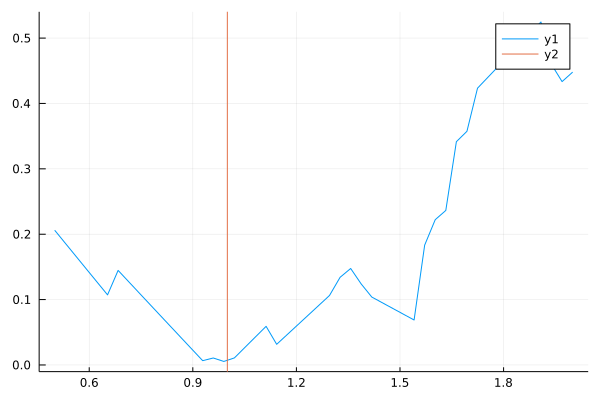

In [11]:
plot(all_D, all_loss)
vline!([D₀])

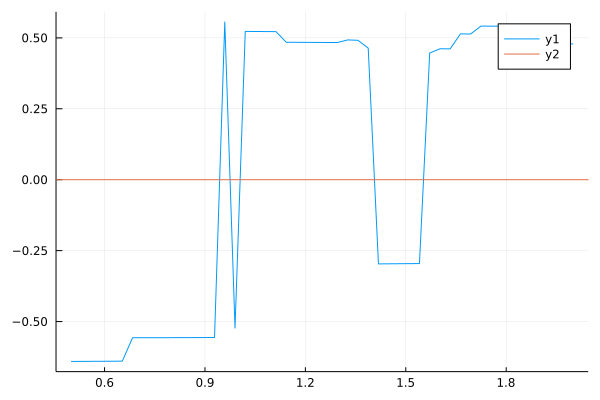

In [12]:
plot(all_D, all_grad)
hline!([0])

## AD with respect to D in order to optimize it

We now use Zygote in order to perform AD on the 2D heat equation and we optimize D using an ADAM gradient descent. 

In [ ]:
function train(loss, p)
    
    θ = [10.]

    opt = ADAM(0.1)
    @epochs 100 hybrid_train!(loss, θ, p, opt)
    
    return θ
    
end

function hybrid_train!(loss, θ, p, opt)
        
    T = T₀
    loss_uD, back_uD = Zygote.pullback(θ -> loss(T, θ, p), θ)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    
    println("Loss: ", loss_uD)
    println("Current parameter: ", θ)
    println("Gradient: ", ∇_uD)
    println("opt: ", opt)
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

In [ ]:
θ₁ = train(loss, p)  #  I STILL GET AN ERROR HERE
D = θ₁[1]

Finally, this is the value for $D$ that we find after performing optimization with respect of the numerical methods:

In [ ]:
D